In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

21.7 +/- 1.9
19.3 +/- 1.7


# Look at all Cs137 data prior to Loma Linda

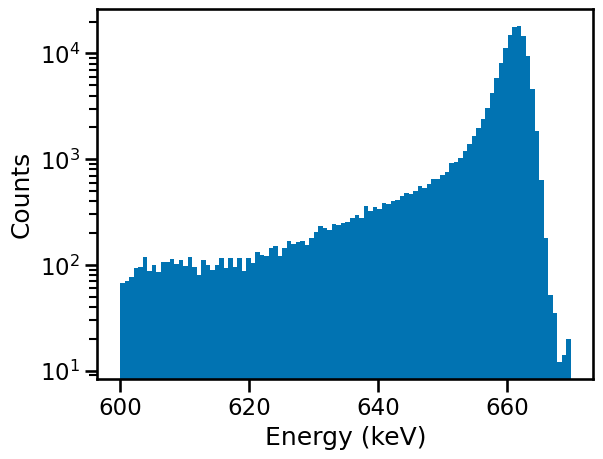

FWHM = 4.04
FWTM = 9.41


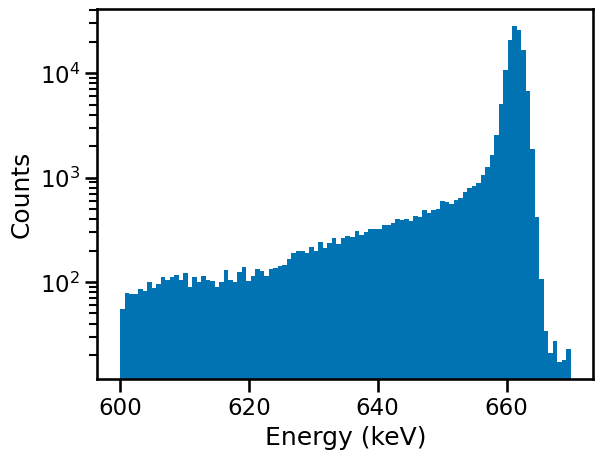

FWHM = 2.7
FWTM = 5.29


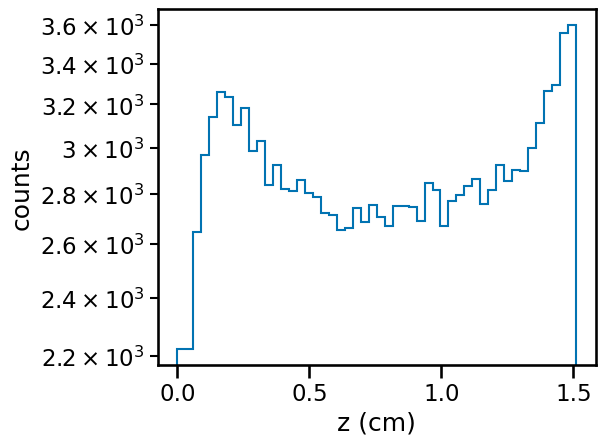

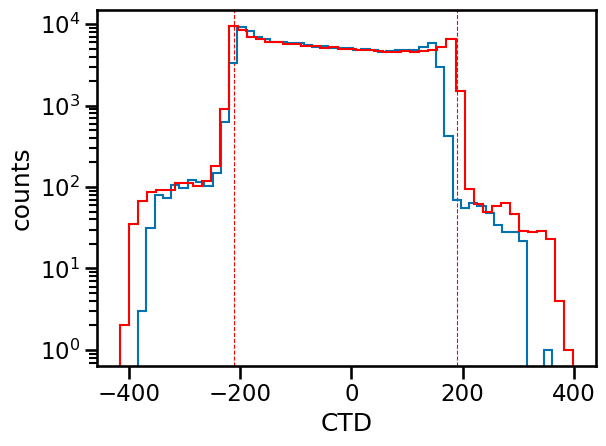

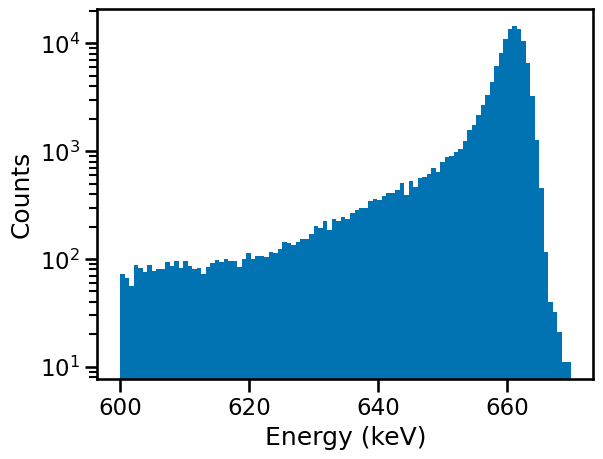

FWHM = 4.41
FWTM = 10.71


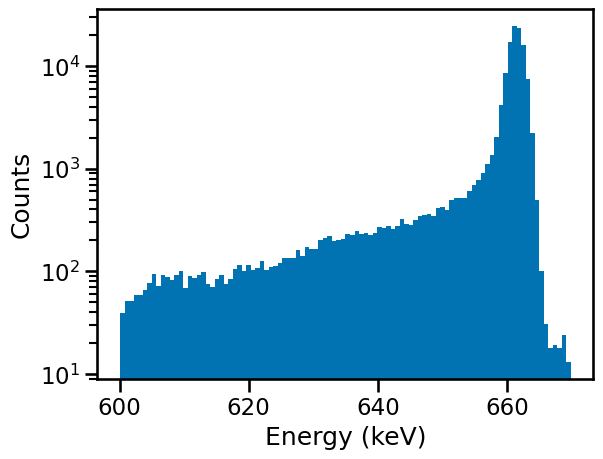

FWHM = 2.77
FWTM = 5.37


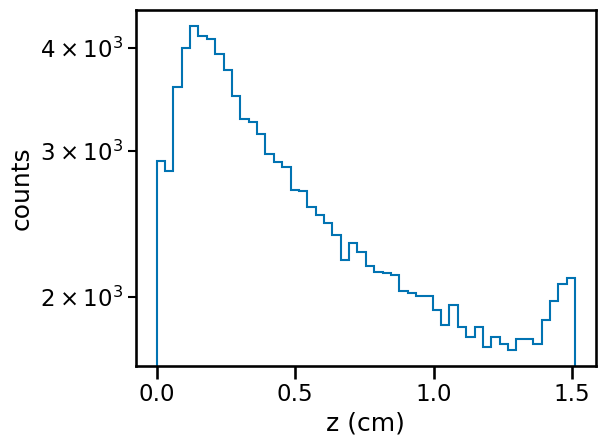

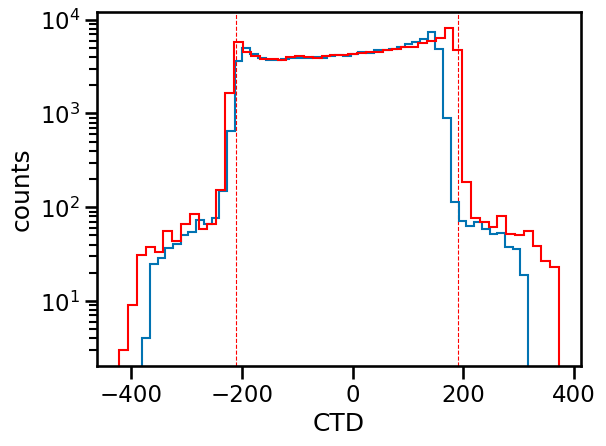

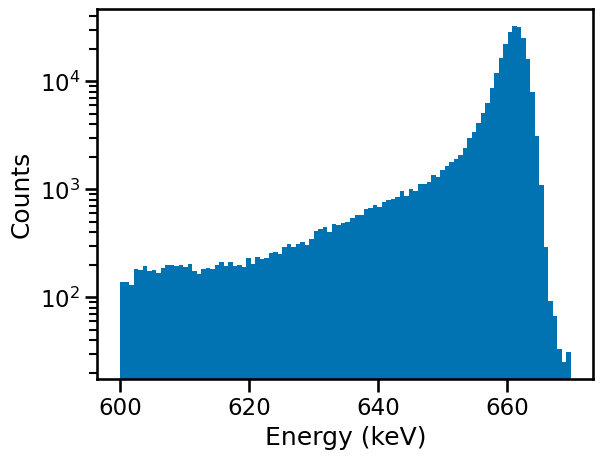

FWHM = 4.21
FWTM = 10.03


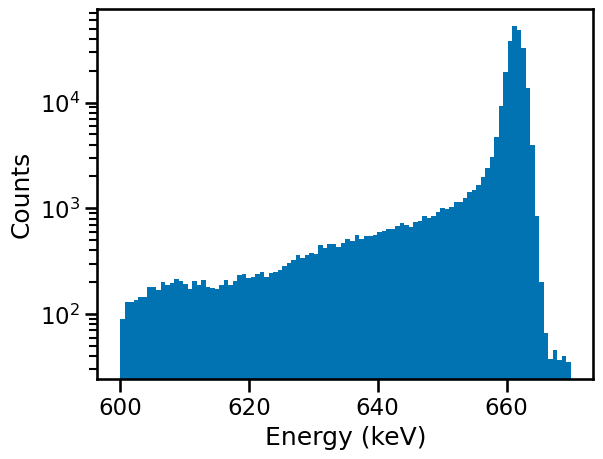

FWHM = 2.73
FWTM = 5.33


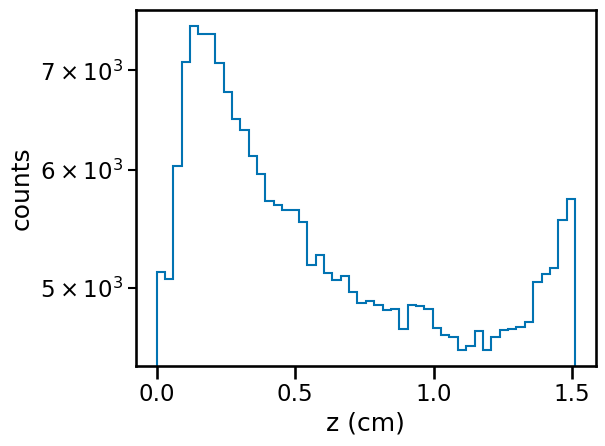

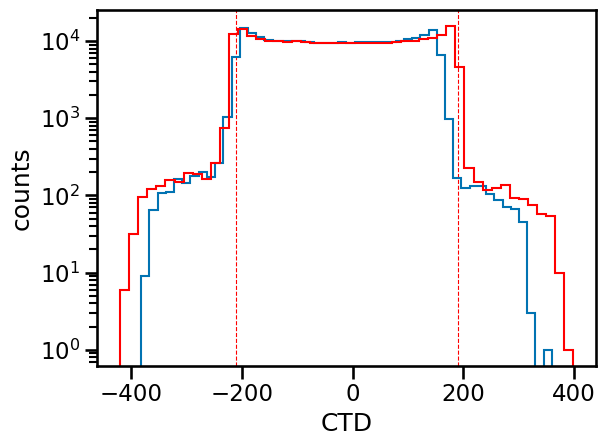

In [2]:
AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_preLL', 'allDC_preLL', 'allACandDC_preLL']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'preLL/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [3]:
depth_correction(df_list[-1], z_list, e_signal_preLL, h_signal_preLL, plot_suffix = 'Cs137allACandDC_preLL')

FWHM = 4.21
FWTM = 10.03
FWHM = 3.56
FWTM = 8.35
FWHM = 2.73
FWTM = 5.33
FWHM = 2.69
FWTM = 5.23


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_err,z_binned,depth_corrected_energy_p,depth_corrected_energy_n
0,25,11,25,660.205139,240.0,17,658.675337,145.0,1.634266e+307,1.634266e+307,0.234105,0.033038,"(0.201, 0.252]",661.797604,658.589894
1,73,11,31,655.807642,285.0,34,660.789426,150.0,1.634266e+307,1.634266e+307,0.081396,0.043679,"(0.0503, 0.101]",657.731553,660.760191
2,191,11,7,663.441611,185.0,14,666.980549,245.0,1.634266e+307,1.634266e+307,0.826595,0.042963,"(0.805, 0.856]",663.750922,667.115494
3,313,11,8,662.525549,155.0,29,658.234542,350.0,1.634266e+307,1.634266e+307,1.437274,0.054104,"(1.409, 1.46]",661.870671,658.739274
4,431,11,12,661.195999,165.0,32,659.252122,360.0,1.634266e+307,1.634266e+307,1.450465,0.059556,"(1.409, 1.46]",660.528522,659.761460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269464,3233669,11,25,661.603411,290.0,1,662.397956,150.0,1.634266e+307,1.634266e+307,0.123342,0.043693,"(0.101, 0.151]",663.449921,662.346554
269465,3233730,11,24,645.373936,275.0,9,657.603027,155.0,1.634266e+307,1.634266e+307,0.225049,0.034338,"(0.201, 0.252]",646.950655,657.519314
269466,3233856,11,23,658.766425,275.0,14,661.566536,145.0,1.634266e+307,1.634266e+307,0.129226,0.039415,"(0.101, 0.151]",660.591799,661.512516
269467,3233939,11,10,659.473632,170.0,31,661.643388,210.0,1.634266e+307,1.634266e+307,0.661387,0.041682,"(0.654, 0.705]",660.119235,661.669767


In [4]:
fit_CCE(z_list, e_signal_preLL, h_signal_preLL, sim_dCCE, plot_suffix = 'Cs137allACandDC_preLL')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 253.9 (chi2/ndof = 4.5)    │              Nfcn = 269              │
│ EDM = 9.78e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 253.9 (chi2/ndof = 4.5)    │              Nfcn = 269              │
│ EDM = 9.78e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ae   │  662.411  │   0.006   │   -0.006   │   0.006    │         │         │       │
│ 1 │ b    │   1.326   │   0.008   │   -0.008   │   0.008    │    0    │         │       │
│ 2 │ c    │   0.547   │   0.005   │   -0.005   │   0.005    │    0    │         │       │
│ 3 │ ah   │  662.114  │   0.005   │   -0.005   │   0.005    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ae           │           b           │           c           │          ah           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.006   │   0.006   │  -0.008   │   0.008   │  -0.005   │   0.005   │  -0.005   │   0.005   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────────────────────┐
│    │       ae        b        c       ah │
├────┼─────────────────────────────────────┤
│ ae │  4.2e-05 3.75e-05 9.96e-06 1.15e-05 │
│  b │ 3.75e-05 6.38e-05 1.29e-05 1.65e-05 │
│  c │ 9.96e-06 1.29e-05 2.68e-05 2.18e-05 │
│ ah │ 1.15e-05 1.65e-05 2.18e-05 2.64e-05 │
└────┴─────────────────────────────────────┘